# Text-based Information Retrieval

## Assignment PART II
### Using wordembedding
We can use the semantic similarity of wordembeddings, such as GloVe and Word2Vec, to obtain better results.
In this part of the exercise, we will the addition analogy (similar to Part I of this assignment) to rank the given documents.


In [1]:
# Loading modules
import os, re
import pandas as pd
from numpy import dot, sum
#from gensim import matutils, models, corpora, similarities
import gensim

# Set up logger that logs (works in jupyter 3!) in console and outputs in file
'''
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='part_II_logs.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)
'''

"\nimport logging\nlogger = logging.getLogger()\nfhandler = logging.FileHandler(filename='part_II_logs.log', mode='a')\nformatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')\nfhandler.setFormatter(formatter)\nlogger.addHandler(fhandler)\nlogger.setLevel(logging.DEBUG)\n"

#### Images to wordvectors

We will use the similarity of wordmodels such as Word2Vec and GloVe to make vectors of each image. These vectors will look like 
>s = w1 + w2 + ... + wn

> With s = the image vector and {w1 .. wn} the words for each image


In [2]:
# Load in a stopword list from
# http://www.lextek.com/manuals/onix/stopwords2.html
stopwords = []
with open('data/stopwordlist.txt', 'r') as f:
    lines = ''.join(f.readlines())
    stopwords = [x for x in lines.split('\n')[2:]]


In [3]:
# Clean input because the wordmodels can not contain every possible combination words and signs
def clean_input(text, stopwords):
    # lowecase and remove linebreaks
    text = text.lower().rstrip()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    # Remove punctuation
    text = re.sub('[!@#$:;%&?,_\.\'\`\"\\\/\(\)\[\]]', '', text)
    text = re.sub('[\-]+', '-', text)
    # Remove sole numbers, dashes or extra spaces
    text = re.sub('[\s][\-]+[\s]', '', text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub('[\s]+', ' ', text)
    # British to American English - at this moment still hardcoded due to lack of library
    text = text.replace('grey', 'gray')
    text = text.replace('colour', 'color')
    text = text.replace('tyre', 'tire')
    text = text.replace('centre', 'center')
    text = text.replace('theatre', 'theater')
    text = text.replace('jewellery','jewelry')
    text = text.replace('aeroplane', 'plane')
    text = text.replace('harbour', 'harbor')
    text = text.replace('moustache','mustache')
    text = text.replace(' axe', ' hatchet')
    text = text.replace('armour', 'armor')
    text = text.replace('stylised', 'stylized')
    text = text.replace('organise', 'organize')
    text = text.replace('plough', 'plow')
    text = text.replace('neighbourhood', 'neighborhood')
    text = text.replace('vapour', 'vapor')
    # some manual fixes of lemmatizing
    text = text.replace('watersid ', 'waterside ')
    text = text.replace('figur ', 'figure ')
    text = text.replace(' graz ', ' graze ')
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text


In [4]:
# Text file parser
# Returns a dictionary with imageid - text in lowercase without stopwords or punctuation
def text_file_parser(filename, stopwords):
    corpus = dict()
    #corpus = pd.DataFrame(columns=('id', 'imageid', 'vec'))
    with open(filename) as f:
        # next(f) # skip first line with the headings
        for doc in f:
            # Split on spaces
            doc_parts = doc.split(" ", 1)
            # If first part is the ID (needed for the queries file)
            if(len(doc_parts[0]) < 6):
                doc_parts = doc.split(" ", 2)
                doc_parts.pop(0)
            # Clean the caption text (remove puctuation etc)
            doc_parts[1] = clean_input(doc_parts[1], stopwords)
            # add the array (or row) to an array
            corpus[len(corpus) + 1] = doc_parts        
    # Transform to dataframe
    df = pd.DataFrame.from_dict(corpus, orient='index')
    df = df.reset_index()
    df.columns = ['index', 'img_id', 'caption']
    return df

In [5]:
# images file to docs dict
print('Parsing documents')
training_docs = text_file_parser('data/target_collection_parsed.txt', stopwords)
docs = []
for text in training_docs['caption']:
    docs.append(text.split())
dictionary = gensim.corpora.Dictionary(docs)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in docs]   
# generate LDA model
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=200, id2word = dictionary, passes=2, alpha='auto')
queries = text_file_parser('data/queries_val_parsed.txt', stopwords)

# Preview
queries

Parsing documents


,index,img_id,caption
0,1,CbnA_e6AW6U7Ycoa,people group holding award pose picture
1,2,XBZPztvt67qkMUdI,man white shirt sit table cut meat plate front...
2,3,PaqtOaYmQmXkqW2i,woman red dress posing hatchet
3,4,IPcFtNL-7EQ6Z0yu,soccer play stand soccer ball front
4,5,IMAD0sq2Fz7HpSgX,white yellow train track
5,6,-gqRDDfPZTGlCfJa,view tall building city
6,7,xsrYb57vl4qiMLDG,hand pick flower vine
7,8,BCjxgJlQ3TD5T8ST,picture army ready sail
8,9,LGxwsl9CtRQ8wW3Y,brick roof house picture
9,10,9LtOvyiygFYoxU8S,man clean mess street


#### Check similarity

In [10]:
tfidf = gensim.models.TfidfModel(corpus)
length = len(corpus)
sim_index = gensim.similarities.Similarity('./tmp/tst',corpus, num_features=length)
print('querying')

'''
# Calculate similarity
#training_docs["sim"] = 0.0
queries['recall'] = 0.0
queries['precision'] = 0.0
for i,r in queries.iterrows():
    
    # Calculate similarity per vector document
    vec_bow = dictionary.doc2bow(r['caption'].split())
    vec_lda = lda[vec_bow]
    sims = index[vec_lda]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    sims = [sim[0] for sim in sims[:1000]]
    
    # Recall
    total_to_find = float(len(training_docs[training_docs.img_id == r['img_id']]))
    correct = 0
    for sim in sims:
        if training_docs[training_docs.index == sim].values[0][1] == r['img_id']:
            correct += 1
    
    amount_found = correct
    recall = float(amount_found/total_to_find)
    queries.set_value(i, 'recall', recall)
    
    # Precision
    precision = float(amount_found/float(1000))
    queries.set_value(i, 'precision', precision)

print('Finished querying')
'''

# Create outputfile if not already exists
#if not os.path.exists(output_file):
#    open(output_file, 'w').close()

# Create a results dataframe that will contain the MAP and average recall for all run queries
results = pd.DataFrame(index=range(0,1000), columns=['map', 'recall'])
results['map'] = 0.0
results['recall'] = 0.0

# Calculate similarity
print ("Calculating precision and recall")
for i,r in queries.iterrows():
    print ("Processing query", i) # Print the current query number
    
    # Calculate similarity per vector document
    vec_bow = dictionary.doc2bow(r['caption'].split())
    vec_lda = lda[vec_bow]
    sims = sim_index[vec_lda]
    
    # order by similarity and get top 1000 results
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    sims = [sim[0] for sim in sims[:1000]]
    
    # Get total amount of images that should be found
    total_to_find = float(len(training_docs[training_docs.img_id == r['img_id']]))
    total_found = 0.0
    current_avg_precision = 0.0
    
    # Iterare over top 1000 found documents
    for index, sim in enumerate(sims):
        if training_docs[training_docs.index == sim].values[0][1] == r['img_id']:
            total_found += 1.0
            
        # Append values to dataframe for precision-recall curve
        current_avg_precision = float(current_avg_precision) + float(total_found/float(index + 1.0))
        curr_results = results.loc[index]
        results.set_value(index, "recall", float(curr_results['recall']) + float(total_found/total_to_find))
        results.set_value(index, "map", float(curr_results['map']) + float(current_avg_precision/float(index + 1.0)))
        
        # Append to the output file
        #with open(output_file,'a') as f:
        #    # Output in the file is structured as:
        #    # query_id 0 sent_id 0 similarity_score 0
        #    f.write(str(r['index'])+' 0 '+str(row['index'])+' 0 '+str(row['sim'])+" 0\n")
    
# Reduce results rows to averages
results['recall'] = results.apply((lambda row: float(float(row['recall'])/1000.0)), axis=1)
results['map'] = results.apply((lambda row: float(float(row['map'])/1000.0)), axis=1)

querying
Calculating precision and recall
Processing query 0
Processing query 1
Processing query 2
Processing query 3
Processing query 4
Processing query 5
Processing query 6
Processing query 7
Processing query 8
Processing query 9
Processing query 10
Processing query 11
Processing query 12
Processing query 13
Processing query 14
Processing query 15
Processing query 16
Processing query 17
Processing query 18
Processing query 19
Processing query 20
Processing query 21
Processing query 22
Processing query 23
Processing query 24
Processing query 25
Processing query 26
Processing query 27
Processing query 28
Processing query 29
Processing query 30
Processing query 31
Processing query 32
Processing query 33
Processing query 34
Processing query 35
Processing query 36
Processing query 37
Processing query 38
Processing query 39
Processing query 40
Processing query 41
Processing query 42
Processing query 43
Processing query 44
Processing query 45
Processing query 46
Processing query 47
Processi

#### Results

In [11]:
print ("Displaying results:")

print ("--")
print ("MAP for best 10:", results.loc[9]['map'])
print ("MAP for best 100:", results.loc[99]['map'])
print ("MAP for best 250:", results.loc[249]['map'])
print ("MAP for best 500:", results.loc[499]['map'])
print ("MAP for best 500:", results.loc[999]['map'])

print ("AVG recall for best 10", results.loc[9]['recall'])
print ("AVG recall for best 100", results.loc[99]['recall'])
print ("AVG recall for best 250", results.loc[249]['recall'])
print ("AVG recall for best 500", results.loc[499]['recall'])
print ("AVG recall for best 500", results.loc[999]['recall'])
print ("--")

# print results
print (results)

Displaying results:
--
MAP for best 10: 0.000808928571429
MAP for best 100: 0.00082053690786
MAP for best 250: 0.000856286376856
MAP for best 500: 0.000841716853142
MAP for best 500: 0.00083324445797
AVG recall for best 10 0.000431324880793
AVG recall for best 100 0.00645000646536
AVG recall for best 250 0.0157190867238
AVG recall for best 500 0.0285282499762
AVG recall for best 500 0.0617653111606
--
          map    recall
0    0.001000  0.000091
1    0.001000  0.000117
2    0.001000  0.000138
3    0.000937  0.000138
4    0.000910  0.000281
5    0.000897  0.000306
6    0.000871  0.000306
7    0.000840  0.000306
8    0.000821  0.000406
9    0.000809  0.000431
10   0.000793  0.000431
11   0.000797  0.000640
12   0.000806  0.000833
13   0.000820  0.001024
14   0.000832  0.001049
15   0.000843  0.001192
16   0.000848  0.001192
17   0.000851  0.001192
18   0.000850  0.001192
19   0.000848  0.001192
20   0.000846  0.001217
21   0.000843  0.001217
22   0.000842  0.001451
23   0.000840  0.00

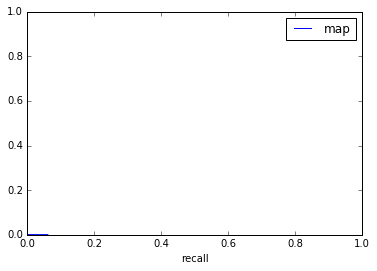

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# Sort by recall
#df = df.sort_values(by=['recall'], ascending=[1])

# Show and save chart
qx = results.plot(x='recall', y='map')
qx.set_xlim([0,1])
qx.set_ylim([0,1])
fig = qx.get_figure()
fig.savefig('results/part2_lda_precision-recall.png')

### Results from calculations on server
For lowering the workload on our computers, we let a server do the calculations and write the results to a csv file.


In [ ]:
# Read in results file
results = pd.DataFrame.from_csv('results/results.csv')

# averages
print "--"
print "AVG recall", results.recall.mean()
print "AVG precision:",  results.precision.mean()
print "--"

# Preview dataframe
results